### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними &ndash; использование рекуррентных нейронных сетей. В этом базовом решении мы демонстрируем, как можно построить хорошее решение задачи соревнования без использования сложного и трудоемкого feature engineering'а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным нейронным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `torch`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import tqdm

# !!! измените "2" на номер доступной вам сuda
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
pd.set_option("display.max_columns", None)

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append("/content/drive/MyDrive/alfa_rnn")

In [5]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-pastel")

### 1. Data Preprocessing

In [6]:
TRAIN_DATA_PATH = r"/content/drive/MyDrive/alfa_rnn/data/train_data"
TEST_DATA_PATH = r"/content/drive/MyDrive/alfa_rnn/data/test_data"

TRAIN_TARGET_PATH = r"/content/drive/MyDrive/alfa_rnn/data/train_target.csv"

In [7]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента.
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [8]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [10]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_0.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_1.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_2.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_4.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_5.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_6.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_8.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_9.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_10.pq
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/test_data/test_data_0.pq
/content/drive/MyDrive/alfa_rnn/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 39.1 s, sys: 24.4 s, total: 1min 3s
Wall time: 1min 25s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [11]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

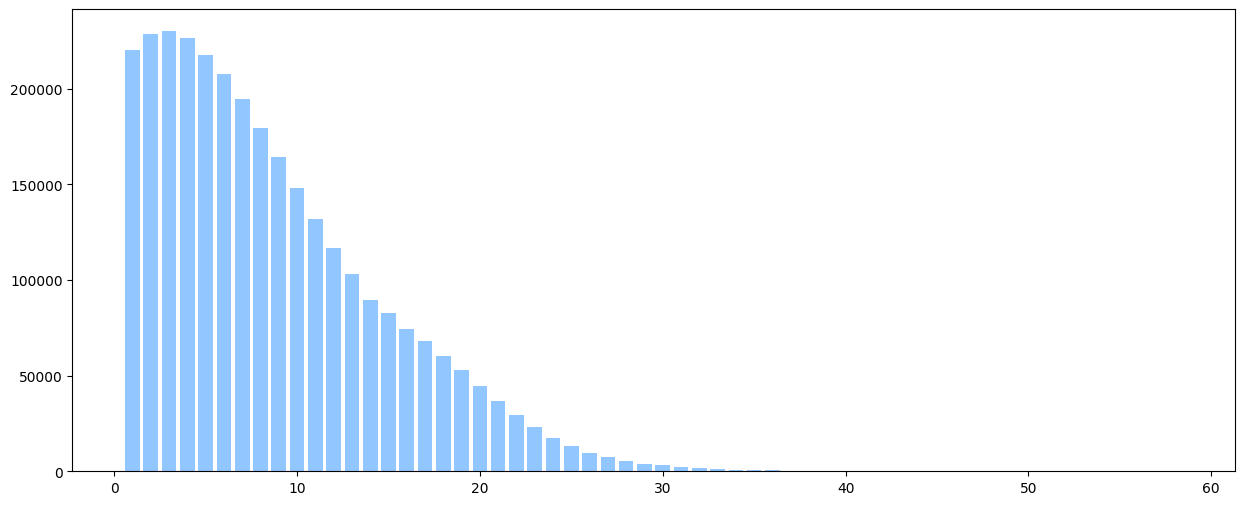

In [12]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

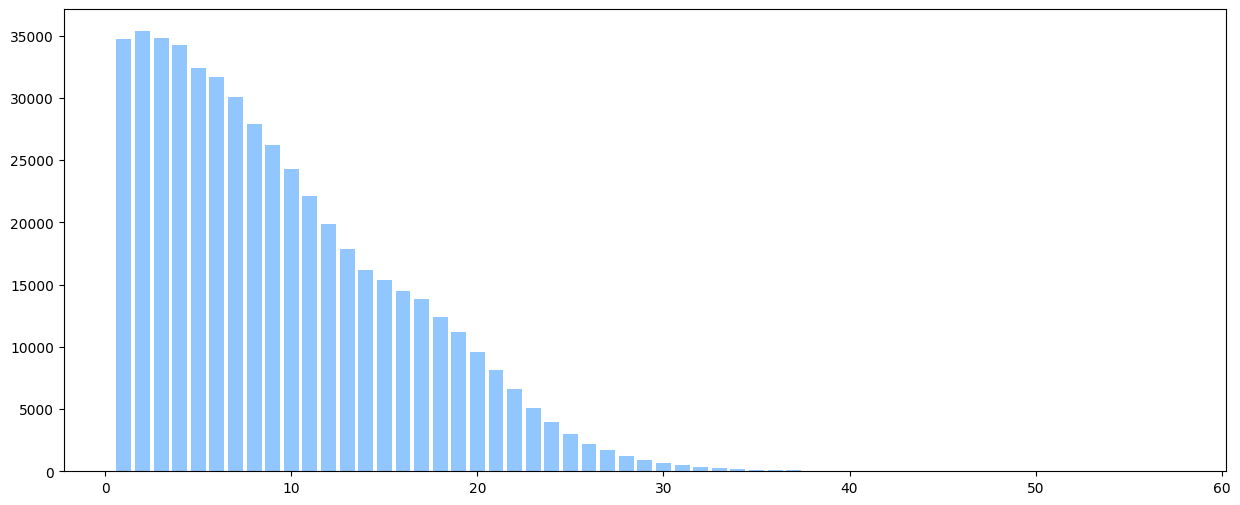

In [13]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [14]:
train_lens.max(), test_lens.max()

(np.uint8(58), np.uint8(57))

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета:
| Длина последовательности | Длина после паддинга |
| :-: | :-:
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [15]:
keys_ = list(range(1, 59))
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [16]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19)}
Feature: pre_since_confirmed, unique values: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17)}
Feature: pre_pterm, unique values: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17)}
Feature: pre_fterm, unique values: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [17]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None,
                                num_parts_to_preprocess_at_once: int = 1,
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")

        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str

        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target,
                                                    save_to_file_path=os.path.join(save_to_path,
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [18]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [19]:
TRAIN_BUCKETS_PATH = r"/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn"
VAL_BUCKETS_PATH = r"/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn"
TEST_BUCKETS_PATH = r"/content/drive/MyDrive/alfa_rnn/data/test_buckets_rnn"

In [20]:
dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])

### Дальше идет первичная обработка данных для обучения

In [21]:
for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    !rm -rf $buckets_path
    !mkdir $buckets_path

In [22]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=1,
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_4.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_6.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_10.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

CPU times: user 9min 34s, sys: 46.2 s, total: 10min 20s
Wall time: 11min 18s


['/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_000.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_001.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_002.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_003.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_004.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_005.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_006.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_007.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_008.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_009.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_010.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/train_buckets_rnn/processed_chunk_011.pkl']

In [23]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=1,
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_4.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_6.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_10.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 8min 37s, sys: 26.4 s, total: 9min 4s
Wall time: 9min 1s


['/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_000.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_001.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_002.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_003.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_004.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_005.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_006.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_007.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_008.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_009.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_010.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/val_buckets_rnn/processed_chunk_011.pkl']

In [24]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=1,
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/test_data/test_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/content/drive/MyDrive/alfa_rnn/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 1min 33s, sys: 8.06 s, total: 1min 41s
Wall time: 1min 52s


['/content/drive/MyDrive/alfa_rnn/data/test_buckets_rnn/processed_chunk_000.pkl',
 '/content/drive/MyDrive/alfa_rnn/data/test_buckets_rnn/processed_chunk_001.pkl']

### 2. Modeling

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [26]:
from data_generators import batches_generator
import pytorch_training
from pytorch_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [27]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))
    #return min(50, (n_cat//2)+1)

In [28]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (np.uint8(20), 9),
 'pre_since_confirmed': (np.uint8(18), 8),
 'pre_pterm': (np.uint8(18), 8),
 'pre_fterm': (np.uint8(17), 8),
 'pre_till_pclose': (np.uint8(17), 8),
 'pre_till_fclose': (np.uint8(16), 8),
 'pre_loans_credit_limit': (np.uint8(20), 9),
 'pre_loans_next_pay_summ': (np.uint8(8), 5),
 'pre_loans_outstanding': (np.uint8(6), 4),
 'pre_loans_total_overdue': (np.uint8(2), 2),
 'pre_loans_max_overdue_sum': (np.uint8(4), 3),
 'pre_loans_credit_cost_rate': (np.uint8(14), 7),
 'pre_loans5': (np.uint8(18), 8),
 'pre_loans530': (np.uint8(20), 9),
 'pre_loans3060': (np.uint8(10), 6),
 'pre_loans6090': (np.uint8(6), 4),
 'pre_loans90': (np.uint8(20), 9),
 'is_zero_loans5': (np.uint8(2), 2),
 'is_zero_loans530': (np.uint8(2), 2),
 'is_zero_loans3060': (np.uint8(2), 2),
 'is_zero_loans6090': (np.uint8(2), 2),
 'is_zero_loans90': (np.uint8(2), 2),
 'pre_util': (np.uint8(20), 9),
 'pre_over2limit': (np.uint8(20), 9),
 'pre_maxover2limit': (np.uint8(20), 9),
 'is_zero_

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [29]:
class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32):
        super(CreditsRNN, self).__init__()
        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])

        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=rnn_units, batch_first=True, dropout=0.0, bidirectional=False)
        self._hidden_size = rnn_units
        self._top_classifier = nn.Linear(in_features=rnn_units, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)

    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)

        _, last_hidden = self._gru(concated_embeddings)
        last_hidden = torch.reshape(last_hidden.permute(1, 2, 0), shape=(batch_size, self._hidden_size))

        classification_hidden = self._top_classifier(last_hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

In [30]:
# NEW MODEL
class CreditsRNN_Bi(nn.Module):
    def __init__(self, features, embedding_projections, hidden_size=128, top_classifier_units=32, n_layers=1, dropout_p=0.2, bidirectional=False, method='GRU'):
        super(CreditsRNN_Bi, self).__init__()

        if bidirectional and hidden_size % 2 != 0:
            raise ValueError("hidden_size must be even when bidirectional is True")

        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])
        self._hidden_size = hidden_size
        self._n_layers = n_layers
        self._bidirectional = bidirectional
        self._n_directions = 2 if bidirectional else 1
        self._dropout_p = dropout_p
        self._method = method

        classifier_input_size = hidden_size * self._n_directions
        rnn_dropout = dropout_p if n_layers > 1 else 0.0

        if self._method == 'GRU':
          self._net = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=rnn_dropout,
                            bidirectional=bidirectional)
        elif self._method == 'LSTM':
          self._net = nn.LSTM(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             dropout=rnn_dropout,
                             bidirectional=bidirectional)
        else:
            raise ValueError("Method must be 'GRU' or 'LSTM'")

        self._top_classifier = nn.Linear(in_features=classifier_input_size, out_features=top_classifier_units)
        self._activation_function = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        self._dropout = nn.Dropout(self._dropout_p)

    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        concated_embeddings = self._dropout(concated_embeddings)

        _, last_hidden = self._net(concated_embeddings)
        last_hidden = last_hidden[0] if self._method == 'LSTM' else last_hidden

        # Last layer (num_layers, num_directions, batch, hidden_size)
        last_hidden = last_hidden.view(self._n_layers, self._n_directions, batch_size, self._hidden_size)
        last_layer_hidden = last_hidden[-1]  # (num_directions, batch, hidden_size)

        combined_hidden = last_layer_hidden.permute(1, 0, 2).reshape(batch_size, -1)
        combined_hidden = self._dropout(combined_hidden)

        classification_hidden = self._top_classifier(combined_hidden)
        activation = self._activation_function(classification_hidden)
        raw_output = self._head(activation)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

In [31]:
# NEW MODEL
class CreditsRNN_Bi_pool_drop(nn.Module):
    def __init__(self, features, embedding_projections, hidden_size=128, top_classifier_units=32, n_layers=1, dropout_p=0.2, bidirectional=False, method='GRU'):
        super(CreditsRNN_Bi_pool_drop, self).__init__()

        if bidirectional and hidden_size % 2 != 0:
            raise ValueError("hidden_size must be even when bidirectional is True")

        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])

        self._hidden_size = hidden_size
        self._n_layers = n_layers
        self._bidirectional = bidirectional
        self._n_directions = 2 if bidirectional else 1
        self._dropout_p = dropout_p
        self._method = method

        rnn_dropout = dropout_p if n_layers > 1 else 0.0

        if self._method == 'GRU':
          self._net = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=rnn_dropout,
                            bidirectional=bidirectional)
        elif self._method == 'LSTM':
          self._net = nn.LSTM(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             dropout=rnn_dropout,
                             bidirectional=bidirectional)
        else:
            raise ValueError("Method must be 'GRU' or 'LSTM'")

        # Calculating input size for classifier
        pool_features = hidden_size * self._n_directions * 2  # max + avg pooling
        classifier_input_size = hidden_size * self._n_directions + pool_features

        self._top_classifier = nn.Linear(in_features=classifier_input_size, out_features=top_classifier_units)
        self._activation_function = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        self._dropout = nn.Dropout(self._dropout_p)


    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        concated_embeddings = self._dropout(concated_embeddings)

        output, last_hidden = self._net(concated_embeddings)
        last_hidden = last_hidden[0] if self._method == 'LSTM' else last_hidden

        # Extracting the last layer [n_layers, n_directions, batch, hidden_size]
        last_hidden = last_hidden.view(self._n_layers, self._n_directions, batch_size, self._hidden_size)
        last_layer_hidden = last_hidden[-1]  # [n_directions, batch, hidden_size]

        # Combining directions
        rnn_features = last_layer_hidden.permute(1, 0, 2).reshape(batch_size, -1)  # [batch, n_directions*hidden_size]

        # Pulling along the time axis of outputs RNN (output: [batch, seq_len, n_directions*hidden_size])
        output_pool = output.permute(0, 2, 1)  # [batch, features, seq_len]
        max_pool = F.adaptive_max_pool1d(output_pool, 1).view(batch_size, -1)
        avg_pool = F.adaptive_avg_pool1d(output_pool, 1).view(batch_size, -1)
        pooled_features = torch.cat([max_pool, avg_pool], dim=1)

        # Concatenation of all features
        combined_features = torch.cat([rnn_features, pooled_features], dim=1)
        combined_features = self._dropout(combined_features)

        # Classifier
        classification = self._top_classifier(combined_features)
        activation = self._activation_function(classification)
        raw_output = self._head(activation)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

In [32]:
# NEW MODEL
class RNN_pooling(nn.Module):
    def __init__(self, features, embedding_projections, hidden_size=128, top_classifier_units=128, dense_units=32, n_layers=1, dropout_p=0.2, bidirectional=False, method='GRU'):
        super(RNN_pooling, self).__init__()

        if bidirectional and hidden_size % 2 != 0:
            raise ValueError("hidden_size must be even when bidirectional is True")

        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])
        self._hidden_size = hidden_size
        self._n_layers = n_layers
        self._bidirectional = bidirectional
        self._n_directions = 2 if bidirectional else 1
        self._dropout_p = dropout_p
        self._method = method

        rnn_input_size = sum(embedding_projections[x][1] for x in features)
        rnn_dropout = dropout_p if n_layers > 1 else 0.0

        if self._method == 'GRU':
          self._net = nn.GRU(input_size=rnn_input_size,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=rnn_dropout,
                            bidirectional=bidirectional)
        elif self._method == 'LSTM':
          self._net = nn.LSTM(input_size=rnn_input_size,
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             dropout=rnn_dropout,
                             bidirectional=bidirectional)
        else:
            raise ValueError("Method must be 'GRU' or 'LSTM'")

        # Calculation of the feature dimension
        self._emb_pool_size = 2 * rnn_input_size  # max + avg poolingо embed
        self._rnn_hidden_pool_size = 2 * hidden_size * self._n_directions  # max + avg pooling hidden
        self._rnn_last_hidden_size = hidden_size * self._n_directions

        # Total size of the features
        total_features = (self._rnn_last_hidden_size +
                        self._rnn_hidden_pool_size +
                        self._emb_pool_size)

        # Classifier
        self._top_classifier = nn.Linear(in_features=total_features, out_features=top_classifier_units)
        self._activation_function = nn.ReLU()
        self._dense = nn.Linear(in_features=top_classifier_units, out_features=dense_units)
        self._head = nn.Linear(in_features=dense_units, out_features=1)
        self._dropout = nn.Dropout(self._dropout_p)


    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1) # [batch, seq_len, emb_size]
        concated_embeddings = self._dropout(concated_embeddings)

        output, last_hidden = self._net(concated_embeddings)
        last_hidden = last_hidden[0] if self._method == 'LSTM' else last_hidden

        # Extracting the last layer [n_layers, n_directions, batch, hidden_size]
        last_hidden = last_hidden.view(self._n_layers, self._n_directions, batch_size, self._hidden_size)
        last_layer_hidden = last_hidden[-1]  # [n_directions, batch, hidden_size]

        # Combining directions for the last hidden state
        rnn_last_hidden = last_layer_hidden.permute(1, 0, 2).reshape(batch_size, -1)  # [batch, n_directions*hidden_size]

        # Time axis pooling for RNN outputs
        emb_pool = concated_embeddings.permute(0, 2, 1)  # [batch, emb_size, seq_len]
        max_emb_pool = F.adaptive_max_pool1d(emb_pool, 1).view(batch_size, -1)
        avg_emb_pool = F.adaptive_avg_pool1d(emb_pool, 1).view(batch_size, -1)
        emb_pool_features = torch.cat([max_emb_pool, avg_emb_pool], dim=1)

        # Пулинг по временной оси для выходов RNN
        rnn_output = output.permute(0, 2, 1)  # [batch, features, seq_len]
        max_rnn_pool = F.adaptive_max_pool1d(rnn_output, 1).view(batch_size, -1)
        avg_rnn_pool = F.adaptive_avg_pool1d(rnn_output, 1).view(batch_size, -1)
        rnn_pool_features = torch.cat([max_rnn_pool, avg_rnn_pool], dim=1)

        # Concatenation of all features
        combined_features = torch.cat([
            rnn_last_hidden,
            rnn_pool_features,
            emb_pool_features
        ], dim=1)
        combined_features = self._dropout(combined_features)

        # Classifier
        classification = self._top_classifier(combined_features)
        activation = self._activation_function(classification)
        dense_out = self._dense(activation)
        raw_output = self._head(dense_out)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

In [33]:
# NEW MODEL
class BidirectRNN(nn.Module):
    def __init__(self, features, embedding_projections, hidden_size=128, top_classifier_units=32, n_layers=1, dropout_p=0.2, bidirectional=False, method='GRU'):
        super(BidirectRNN, self).__init__()

        if bidirectional and hidden_size % 2 != 0:
            raise ValueError("hidden_size must be even when bidirectional is True")

        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])
        self._hidden_size = hidden_size
        self._n_layers = n_layers
        self._bidirectional = bidirectional
        self._n_directions = 2 if bidirectional else 1
        self._dropout_p = dropout_p
        self._method = method

        rnn_dropout = dropout_p if n_layers > 1 else 0.0
        input_size = sum(embedding_projections[x][1] for x in features)

        if self._method == 'GRU':
          self._net = nn.GRU(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=rnn_dropout,
                            bidirectional=bidirectional)
        elif self._method == 'LSTM':
          self._net = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             dropout=rnn_dropout,
                             bidirectional=bidirectional)
        else:
            raise ValueError("Method must be 'GRU' or 'LSTM'")

        self._top_classifier = nn.Linear(in_features=hidden_size * self._n_directions,
                                         out_features=top_classifier_units)
        self._activation_function = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        self._dropout = nn.Dropout(self._dropout_p)


    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        concated_embeddings = self._dropout(concated_embeddings)

        _, last_hidden = self._net(concated_embeddings)
        last_hidden = last_hidden[0] if self._method == 'LSTM' else last_hidden

        # Extracting the last layer [n_layers, n_directions, batch, hidden_size]
        last_hidden = last_hidden.view(self._n_layers, self._n_directions, batch_size, self._hidden_size)
        last_layer_hidden = last_hidden[-1]  # [n_directions, batch, hidden_size]

        # Combining directions
        if self._bidirectional:
            final_hidden = torch.cat([
                last_layer_hidden[0],  # forward
                last_layer_hidden[1]   # backward
            ], dim=-1)
        else:
            final_hidden = last_layer_hidden.squeeze(0)  # [batch, hidden_size]

        final_hidden = self._dropout(final_hidden)

        # Classifier
        classification = self._top_classifier(final_hidden)
        activation = self._activation_function(classification)
        raw_output = self._head(activation)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

### 3. Training

In [34]:
!rm -rf /content/drive/MyDrive/alfa_rnn/checkpoints
!mkdir /content/drive/MyDrive/alfa_rnn/checkpoints

In [35]:
!rm -rf /content/drive/MyDrive/alfa_rnn/checkpoints/bidirect_rnn
!mkdir /content/drive/MyDrive/alfa_rnn/checkpoints/bidirect_rnn

* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [37]:
path_to_checkpoints = "/content/drive/MyDrive/alfa_rnn/checkpoints/bidirect_rnn"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"),
                   metric_name="ROC-AUC", save_format="torch")

In [38]:
num_epochs = 10
train_batch_size = 256
val_batch_size = 256

In [39]:
model = BidirectRNN(features, embedding_projections, top_classifier_units=64, bidirectional=True).to(device)

In [40]:
model

BidirectRNN(
  (_credits_cat_embeddings): ModuleList(
    (0): Embedding(21, 9, padding_idx=0)
    (1-2): 2 x Embedding(19, 8, padding_idx=0)
    (3-4): 2 x Embedding(18, 8, padding_idx=0)
    (5): Embedding(17, 8, padding_idx=0)
    (6): Embedding(21, 9, padding_idx=0)
    (7): Embedding(9, 5, padding_idx=0)
    (8): Embedding(7, 4, padding_idx=0)
    (9): Embedding(3, 2, padding_idx=0)
    (10): Embedding(5, 3, padding_idx=0)
    (11): Embedding(15, 7, padding_idx=0)
    (12): Embedding(19, 8, padding_idx=0)
    (13): Embedding(21, 9, padding_idx=0)
    (14): Embedding(11, 6, padding_idx=0)
    (15): Embedding(7, 4, padding_idx=0)
    (16): Embedding(21, 9, padding_idx=0)
    (17-21): 5 x Embedding(3, 2, padding_idx=0)
    (22-24): 3 x Embedding(21, 9, padding_idx=0)
    (25-27): 3 x Embedding(3, 2, padding_idx=0)
    (28-38): 11 x Embedding(5, 3, padding_idx=0)
    (39): Embedding(6, 4, padding_idx=0)
    (40-47): 8 x Embedding(5, 3, padding_idx=0)
    (48): Embedding(6, 4, padding_

In [41]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [42]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size,
                shuffle=True, print_loss_every_n_batches=500, device=device)

    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)

    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))

    train_roc_auc = eval_model(model, dataset_train, batch_size=train_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.760119).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7625537579704255, val ROC AUC: 0.7601187488610204
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.760119 --> 0.770983).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7762780986191876, val ROC AUC: 0.770982733443311
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770983 --> 0.777348).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7833464417722461, val ROC AUC: 0.7773481543733924
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777348 --> 0.778403).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7860885300618216, val ROC AUC: 0.7784032399828185
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.770734. Current best: 0.778403
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.779120872884878, val ROC AUC: 0.7707344514289951
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.778403 --> 0.780286).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7902943993558149, val ROC AUC: 0.780286283385765
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.778844. Current best: 0.780286
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.7909130556853639, val ROC AUC: 0.7788437482318102
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.780286 --> 0.781773).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Train ROC AUC: 0.7948436088538575, val ROC AUC: 0.7817725101644759
Starting epoch 9


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779189. Current best: 0.781773
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 9 completed. Train ROC AUC: 0.7953615556106954, val ROC AUC: 0.7791885889889245
Starting epoch 10


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.781773 --> 0.781971).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 10 completed. Train ROC AUC: 0.7985870320348156, val ROC AUC: 0.7819705745805953
CPU times: user 39min 50s, sys: 2min 19s, total: 42min 10s
Wall time: 58min 40s


### 4. Submission

* Подготовим посылку в проверяющую систему

In [43]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))

<All keys matched successfully>

In [44]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

Test predictions: 0it [00:00, ?it/s]

In [45]:
test_preds.head()

,id,score
0,3000014,-3.051522
1,3000020,-1.946713
2,3000027,-3.042217
3,3000043,-1.888311
4,3000049,-3.399183


In [ ]:
test_preds.shape

(500000, 2)

In [ ]:
submission_name = "torch_submission_150424.csv"

In [ ]:
test_preds.to_csv(submission_name, index=None)